Importing needed libraries

In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as trfms

from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk, load_dataset

/home/denis/Coding/projects/TESTImageSegmentation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selecting CUDA device if available. Set multiprocessing method to 'spawn' instead of 'fork' as it works better on UNIX-system.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading dataset

In [3]:
dataset = load_from_disk("./data/urbansyncityscapes")
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Some samples

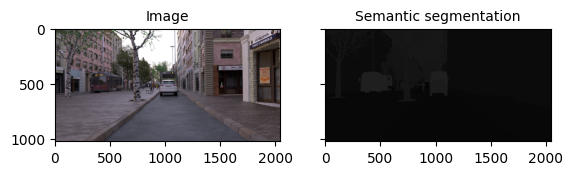

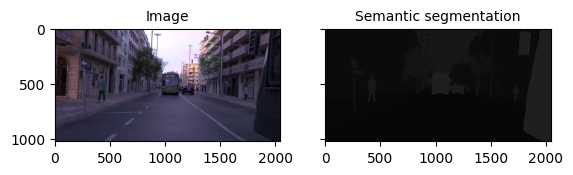

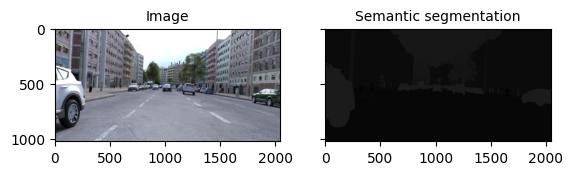

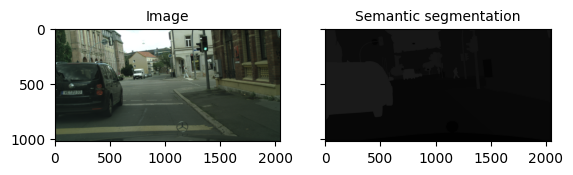

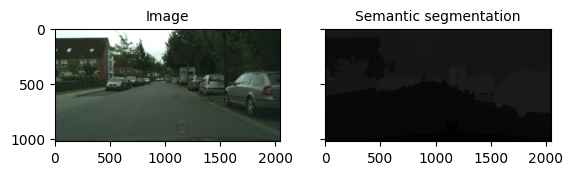

In [4]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1, 2, sharey=True)
    ax1.imshow(image)
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(semantic_segmentation)
    ax2.set_title('Semantic segmentation', fontsize='medium')


Specifying augmentation for train and validation set. Test set would be used without any augmentation. 

In [ ]:
class InstanceAugmentation:
    """
    Transformation of both image and mask. Geometric transformation would be
    in alignment with each other. Color transformation is applied specifically
    for image.
    """
    def __init__(self, geometry_transform = None, color_transform = None):
        self.geometry_transform = geometry_transform
        self.color_transform = color_transform

    def __call__(self, image, mask):
        if self.geometry_transform:
            seed = random.randint(0, 2**32)
            torch.manual_seed(seed)
            image = self.geometry_transform(image)
            torch.manual_seed(seed)
            mask = self.geometry_transform(mask)

        if self.color_transform:
            image = self.color_transform(image)

        return image, mask

In [ ]:
train_transforms_geometry = trfms.Compose([
    trfms.Resize((224, 224)),
    trfms.RandomHorizontalFlip(),
    trfms.RandomApply(transforms=[
        trfms.Resize(size=(512, 512))
    ], p=0.5),
    trfms.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3))
])
train_transforms_color = trfms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.4, hue=0.3)

train_transform = InstanceAugmentation(train_transforms_geometry, train_transforms_color)

In [13]:
val_transforms_geometry = trfms.Compose([
    trfms.RandomHorizontalFlip(),
    trfms.RandomAffine(degrees=(-15, 15), scale=(0.8, 1.2)),
])
val_transforms_color = trfms.ColorJitter(brightness=0.1, contrast=0.1)

val_transform = InstanceAugmentation(val_transforms_geometry, val_transforms_color)

Augmented samples

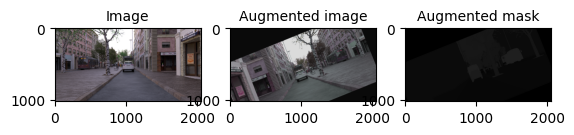

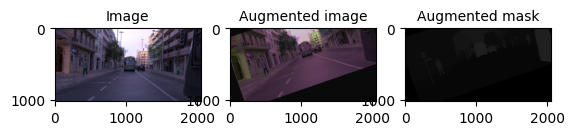

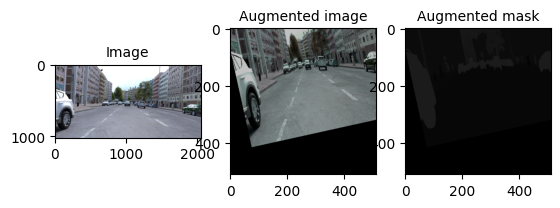

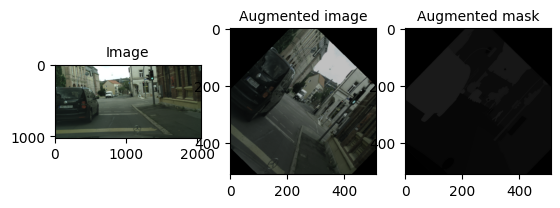

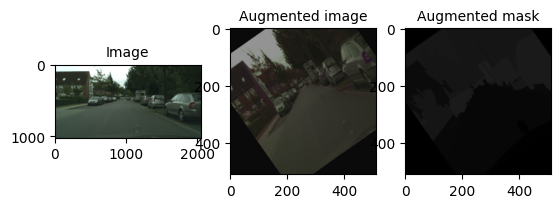

In [35]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    aug_image, aug_mask = train_transform(image, semantic_segmentation)
    fig = plt.figure()
    ax1, ax2, ax3 = fig.subplots(1, 3)
    ax1.imshow(np.array(image))
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(aug_image)
    ax2.set_title('Augmented image', fontsize='medium')
    ax3.imshow(aug_mask)
    ax3.set_title('Augmented mask', fontsize='medium')

Making a pytorch Dataset with 

In [9]:
class StreetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform_geometry  = None, transform_color = None):
        super().__init__()
        self.dataset = dataset
        self.transform_geometry = transform_geometry
        self.transform_color = transform_color

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx : int):
        sample = self.dataset[idx]
        image = np.array(sample['image'])
        mask = np.array(sample['semantic_segmentation'])[:,:,0]

        if self.transform_geometry:
            image = self.transform_geometry(image, )
            mask = self.transform_geometry(mask)

        if self.transform_color:
            image = self.transform_color(image)

        image = torch.Tensor(image).float()
        mask = torch.Tensor(mask).long()
        return image, mask